In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import numpy as np 
sns.set()


df = pd.read_csv('summer_internship_takehome.csv')

#distribution histogram
def histogram(df, metric):
    fig,ax = plt.subplots(figsize=(10,10))
    n,bins,patches = ax.hist(df, 20, density=1, facecolor='blue', alpha=0.5, edgecolor='black')
    ax.set_title(f'Distribution of {metric} Profit Margin', fontsize=15)
    ax.set_xlabel(f'{metric} Profit Margin (%)', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    
#line plot 
def line_plot(df, metric):
    fig,ax = plt.subplots(figsize=(10,10))
    ax.plot(list(df.columns), [sum(df[column]) for column in df.columns])
    ax.set_title(f"Aggregate {metric} Revenue", fontsize=15)
    ax.set_xlabel(f'{metric} Timeframe')
    ax.set_ylabel(f'Sum {metric} Revenue', fontsize=12)
    

#calculating profit margin ((gross revenue - (fixed + variable + rent))/gross revenue) * 100
df['profit_margin'] = (df['Gross revenue'] - (df['Fixed cost'] + df['Variable cost'] + df['Rental cost']))/(df['Gross revenue']) * 100

#getting aggregate median and mean profit margins
df_mean = df.groupby('Location number').mean()['profit_margin']
df_median = df.groupby('Location number').median()['profit_margin']

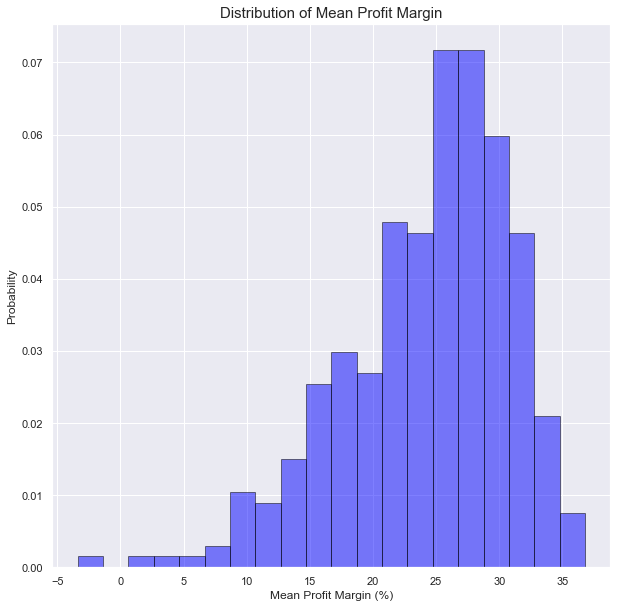

In [28]:
#distribution of median profit margin
histogram(df_mean, 'Mean')

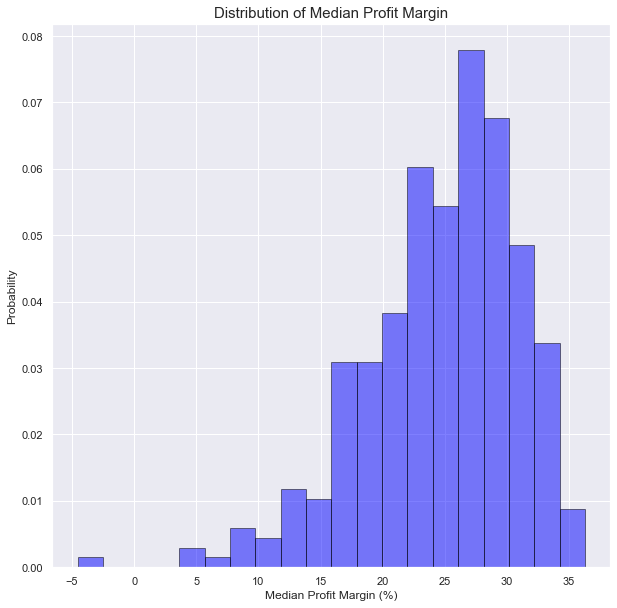

In [29]:
#distribution of median profit margin
histogram(df_median, 'Median')

In [30]:
#calculating monthly & quarterly revenue by transposing dataframe and aggregating into months/quarterly respectively
df_monthly = pd.pivot_table(df, index='Location number', columns='Month', values='Gross revenue')
df_monthly.columns = 'Jan Feb Mar Apr May Jun Jul Aug Sept Oct Nov Dec'.split(' ')

#quarterly revenue 
dic = {}
count = 1
for index in range(0, len(df_monthly.columns), 3):
    quarter = list(df_monthly.columns)[index:index+3]
    revenue_list = [sum(df_monthly[month]) for month in quarter]
    dic[f"Q{count}"] = sum(revenue_list)
    count += 1
df_quarterly = pd.DataFrame(dic, index=[0])

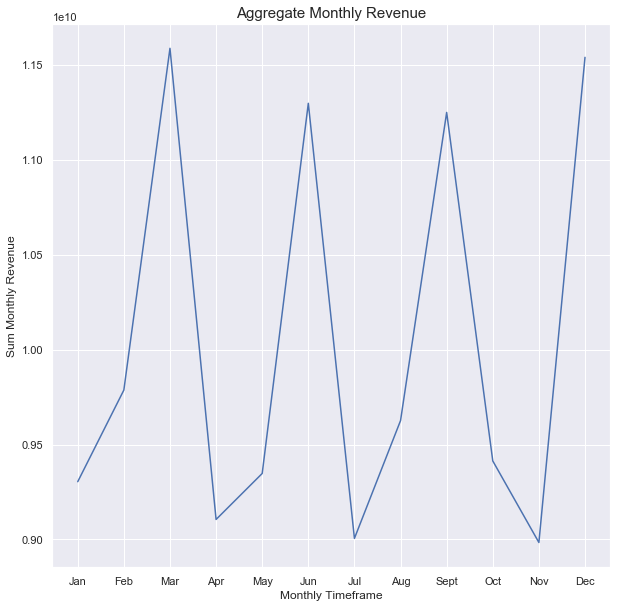

In [31]:
line_plot(df_monthly, 'Monthly')

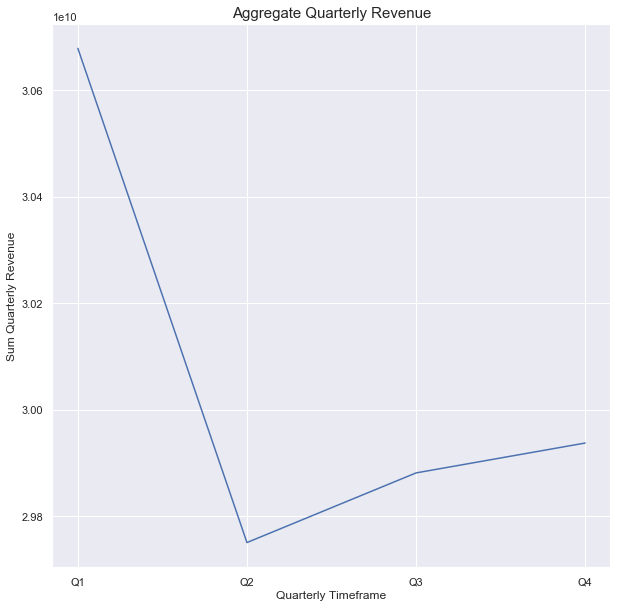

In [32]:
line_plot(df_quarterly, 'Quarterly')

In [33]:
#adjusting rent by taking average rent of each state and adding that to owned locations
mean_monthly_rent = df[df['Owned'] == False].groupby('State').mean()['Rental cost'].to_dict()
adjusted_df = df.copy()
adjusted_df['Rental cost'] = adjusted_df.apply(lambda row: mean_monthly_rent[row.State] if row.Owned else row['Rental cost'], axis=1)

#looking at adjusted median and mean profit margin
adjusted_mean = adjusted_df.groupby('Location number').mean()['profit_margin']
adjusted_median = adjusted_df.groupby('Location number').median()['profit_margin']

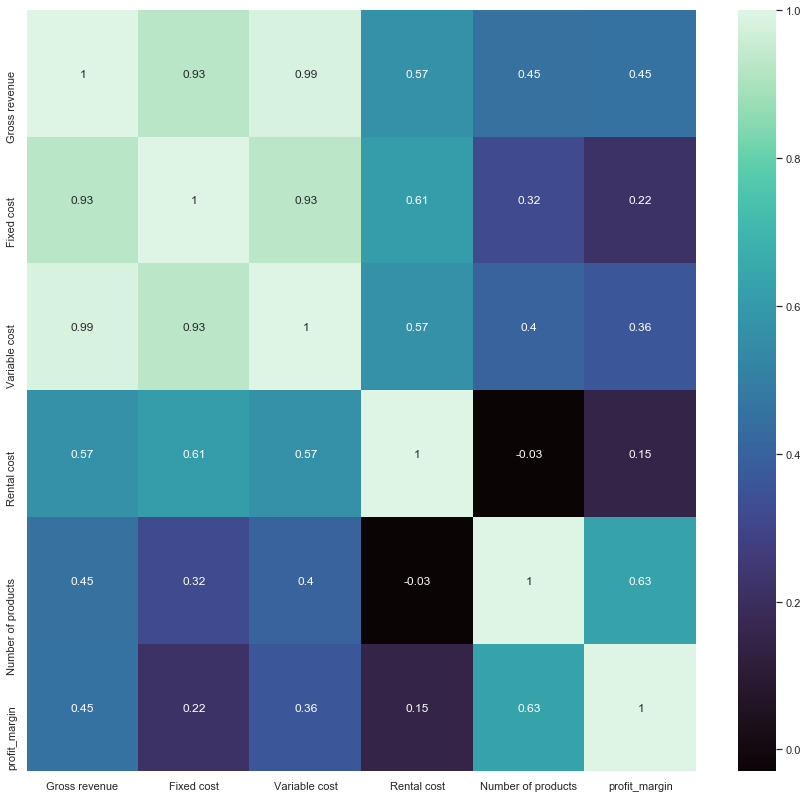

In [34]:
#looking at correlation between quantitative variables (dropped classification variables)
plt.figure(figsize=(15,14))
sns.heatmap(adjusted_df[list(adjusted_df.drop(columns='Owned').columns)[2:]].corr(), annot=True, cmap='mako')

In [44]:
#creating x and y trains for regression models
from sklearn.model_selection import train_test_split
model_df = adjusted_df.copy()

#turning state (categorical variable) into numerical representation 
state_list = pd.get_dummies(model_df['State'])
model_df = pd.concat([model_df.drop(['State'], 1), state_list], 1)
state_categories = state_list.columns

x_data = model_df.drop(columns = ['Location number', 'Owned', 'profit_margin', 'Gross revenue', 'Fixed cost', 'Variable cost', 'Rental cost'] + list(state_categories))
y_data = model_df['profit_margin']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, train_size = 0.8)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [45]:
#normalizing data by centering variable at zero and standardizing variance at 1
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler() 
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))

x_val = scaler.fit_transform(x_val)
y_val = scaler.fit_transform(y_val.reshape(-1,1))

#running regression models

#MLPRegression
reg = MLPRegressor(random_state=42, solver='lbfgs', max_iter=10000, activation='tanh', hidden_layer_sizes=(20, 10, 3))
reg = reg.fit(x_train, y_train)

#Lasso Regression 
lasso = Lasso()
lasso = lasso.fit(x_train, y_train)

#Ridge Regression 
ridge = Ridge()
ridge = ridge.fit(x_train, y_train)

#Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = rf.fit(x_train, y_train)

C:\Users\Philip\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Philip\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [46]:
from sklearn.metrics import mean_squared_error
def mse(model, model_name):
    return f"The MSE of {model_name} model is {mean_squared_error(model.predict(x_val), y_val)}"

model_dic = {key:value for key,value in zip(['MLPRegressor', 'Lasso', 'Ridge', 'Random Forest'], [reg, lasso, ridge, rf])}

for key in model_dic: 
    print(mse(model_dic[key], key))

The MSE of MLPRegressor model is 1.1263040423118176
The MSE of Lasso model is 1.0000000000000002
The MSE of Ridge model is 0.5827672887542434
The MSE of Random Forest model is 0.8156870270861964


In [47]:
#permutation importance
perm = PermutationImportance(ridge).fit(x_train, y_train)
weights = eli5.show_weights(perm, feature_names=x_data.columns.tolist())
weights

Weight,Feature
0.8126 ± 0.0537,Number of products
0.0007 ± 0.0010,Month


The pearson coefficient is 0.6461409781263874


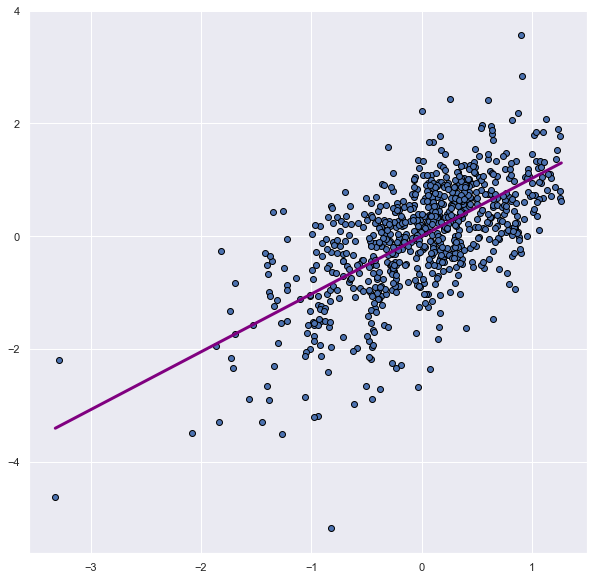

In [48]:
from scipy.stats import pearsonr

x = [float(i) for i in list(ridge.predict(x_val))]
y = [float(i) for i in list(y_val)]
pearson_coefficient = pearsonr(x, y)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, edgecolor='black')
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='purple', linewidth=3, label='Best Fit')

print(f"The pearson coefficient is {pearson_coefficient[0]}")